In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde

In [2]:
def calculate_error_bounds(ds):
    
    pem = ds.mean(dim = 'ensemble_member')
    psd = ds.std(dim = 'ensemble_member', ddof=1)
    
    upperbound = pem + psd
    upperbound['aice'] = upperbound.aice.where(upperbound.aice < 1, 1)
    lowerbound = pem - psd 
    
    return upperbound, lowerbound, pem

Load in the free ensemble

In [3]:
free_ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE/free_ens.nc')

Load in the individual cases

In [4]:
alg_info = 'f1_NORM'
case_list = ['SIT_'+alg_info+'_test','SIC_'+alg_info+'_test','AIC_'+alg_info+'_test']

CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/postprocessed_ens.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    
    CASES.append(ds)

#### Aggregate line plots

In [23]:
file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/aggregate_observations.nc"
obs_test = xr.open_dataset(file)
truth = obs_test.sel({"copy": 2})
x = obs_test.time.values[0:1092:3]

/glade/scratch/mollyw/ipykernel_245661/3968343174.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35, fontsize=10)


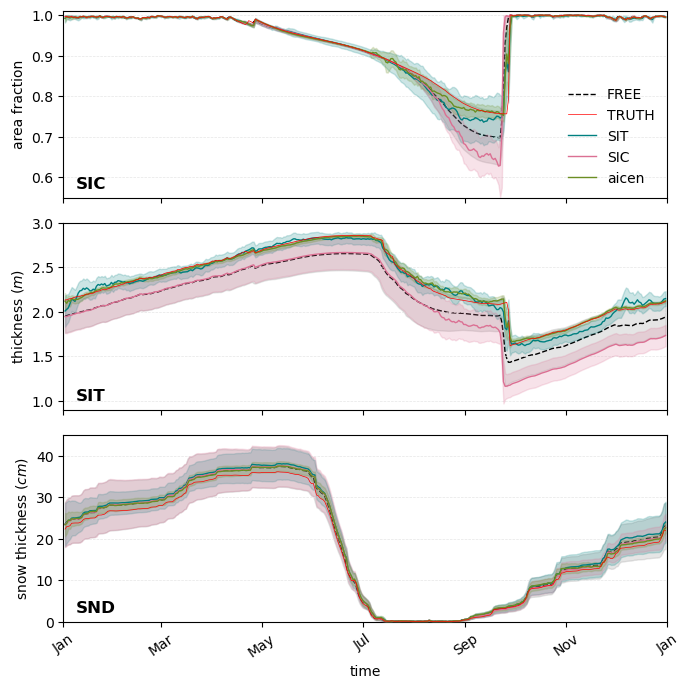

In [24]:
fig, axes = plt.subplots(nrows = 3, figsize = (7,7))

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','aicen']
titles = ['SIT','SIC','SND']

axes[0].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[1].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[2].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)

fup, flw, fem = calculate_error_bounds(free_ds)
axes[0].fill_between(x, flw.aice, fup.aice, alpha=0.2, color = 'grey')
axes[0].plot(x, fem.aice, c = 'black', label = 'FREE',linewidth = 1, linestyle='dashed', zorder = 1)
axes[0].plot(x, truth.observations[1:1092:3], c = 'red', linewidth = 0.5, label = 'TRUTH', zorder = 5)

axes[1].fill_between(x, flw.hi, fup.hi, alpha=0.2, color = 'grey')
axes[1].plot(x, fem.hi, c = 'black', linewidth = 1, linestyle = 'dashed', zorder = 1)
axes[1].plot(x, truth.observations[0:1092:3], c = 'red', linewidth = 0.5, label = 'TRUTH', zorder = 5)

axes[2].fill_between(x, flw.vsnon.sum(dim='ncat')*100, fup.vsnon.sum(dim='ncat')*100, alpha=0.2, color = 'grey')
axes[2].plot(x, fem.vsnon.sum(dim='ncat')*100, c = 'black',linewidth = 1, linestyle = 'dashed', zorder = 1)
axes[2].plot(x, free_ds.isel({'ensemble_member':13}).vsnon.sum(dim='ncat')*100, c = 'red', linewidth = 0.5, zorder = 5)

count = 0
for case in case_list:
    upperbound, lowerbound, pem = calculate_error_bounds(CASES[count])
    axes[0].fill_between(x, lowerbound.aice, upperbound.aice, alpha=0.2, color = colors[count], zorder = 3)
    axes[0].plot(x, pem.aice, c = colors[count],label = labels[count], linewidth = 1, zorder = 4)
           
    axes[1].fill_between(x, lowerbound.hi, upperbound.hi, alpha=0.2, color = colors[count], zorder = 3)
    axes[1].plot(x, pem.hi, c = colors[count], linewidth = 1, zorder = 4)
    
    axes[2].fill_between(x, lowerbound.vsnon.sum(dim='ncat')*100, upperbound.vsnon.sum(dim='ncat')*100, alpha=0.2, color = colors[count], zorder = 3)
    axes[2].plot(x, pem.vsnon.sum(dim='ncat')*100, c = colors[count], linewidth = 1, zorder = 4)
    count +=1 

    

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35, fontsize=10)

axes[0].set_ylim([0.55,1.01])
axes[0].set_xlim([365*41+10, 365*42+10])
axes[0].set_ylabel('area fraction', fontsize=10)
axes[0].legend(frameon=False, loc = 'lower right')

axes[1].set_ylim([0.9,3])
axes[1].set_xlim([365*41+10, 365*42+10])
# axes[1].set_xlabel('time', fontsize=12, fontweight='bold', color='grey')
axes[1].set_ylabel('thickness $(m)$', fontsize=10)

axes[2].set_ylim([0,45])
axes[2].set_xlim([365*41+10, 365*42+10])
axes[2].set_xlabel('time')
axes[2].set_ylabel('snow thickness $(cm)$', fontsize=10)

axes[0].text(0.02, 0.05, titles[1],
             transform=axes[0].transAxes,
             fontsize=12, fontweight='bold')
axes[1].text(0.02, 0.05, titles[0],
             transform=axes[1].transAxes,
             fontsize=12, fontweight='bold')
axes[2].text(0.02, 0.05, titles[2],
             transform=axes[2].transAxes,
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/'+alg_info+'_lineplots.png', dpi=300, bbox_inches='tight')

#### Categorized Line Plots

In [5]:
file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/itd_observations.nc"
obs_test = xr.open_dataset(file)
truth = obs_test.sel({"copy": 2})
x = obs_test.time.values[0:365*10:10]

/glade/scratch/mollyw/ipykernel_293479/311577295.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2][i].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation=50)
/glade/scratch/mollyw/ipykernel_293479/311577295.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2][i].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation=50)
/glade/scratch/mollyw/ipykernel_293479/311577295.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2][i].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation=50)
/glade/scratch/mollyw/ipykernel_293479/311577295.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2][i].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation=50)
/glade/scratch/mollyw/ipykernel_293479/3

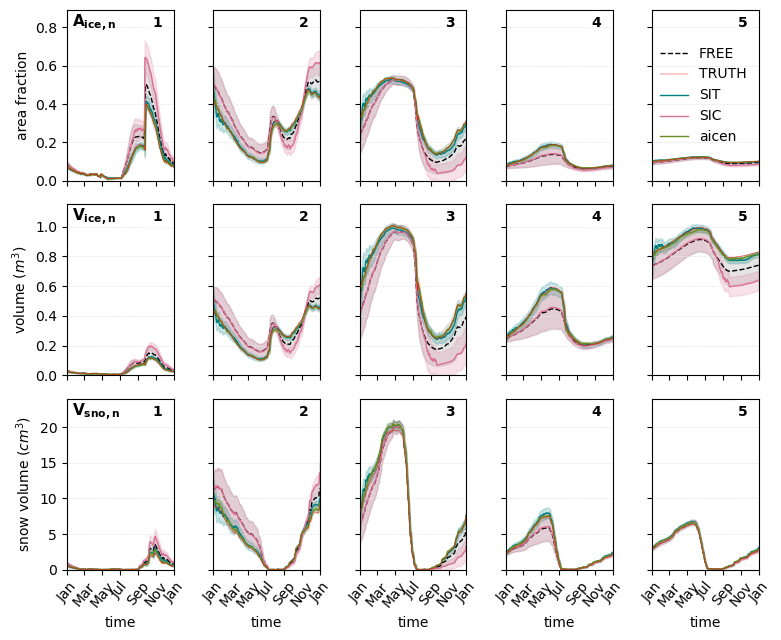

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize=(8,6.5))

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','aicen']
titles = ['aicen','vicen','vsnon']

fup, flw, fem = calculate_error_bounds(free_ds)

for i in range(0, 5):
    aice_obs = truth.observations[i+5:365*10:10]
    vice_obs = truth.observations[i:365*10:10]
    vsno_obs = free_ds.isel({'ensemble_member':13}).vsnon.isel({'ncat':i}) * 100
    
    axes[0][i].plot(x, fem.aicen.isel(ncat=i), color = 'black', linewidth = 1, linestyle='dashed', label = 'FREE')
    axes[0][i].fill_between(x, flw.aicen.isel(ncat=i), fup.aicen.isel(ncat=i), alpha=0.2, color = 'grey')
    axes[1][i].plot(x, fem.vicen.isel(ncat=i), color = 'black', linewidth = 1, linestyle='dashed')
    axes[1][i].fill_between(x, flw.vicen.isel(ncat=i), fup.vicen.isel(ncat=i), alpha=0.2, color = 'grey')
    axes[2][i].plot(x, fem.vsnon.isel(ncat=i)*100, color = 'black', linewidth = 1, linestyle='dashed')
    axes[2][i].fill_between(x, flw.vsnon.isel(ncat=i)*100, fup.vsnon.isel(ncat=i)*100, alpha=0.2, color = 'grey')
    
    axes[0][i].plot(x, aice_obs, color = 'red', linewidth = 0.3, label = 'TRUTH', zorder = 5)
    axes[1][i].plot(x, vice_obs, color = 'red', linewidth = 0.3, zorder = 5)
    axes[2][i].plot(x, vsno_obs, color = 'red', linewidth = 0.3, zorder = 5)
               
    for count in range(0, len(CASES)):
        
        pup, plw, pem = calculate_error_bounds(CASES[count])
        
        # Effect on volume categories
        axes[0][i].plot(x, pem.aicen.isel(ncat=i), color = colors[count], linewidth = 1, label = labels[count])
        axes[0][i].fill_between(x, plw.aicen.isel(ncat=i), pup.aicen.isel(ncat=i), alpha=0.2, color = colors[count])

        axes[1][i].plot(x, pem.vicen.isel(ncat=i), color = colors[count], linewidth = 1)
        axes[1][i].fill_between(x, plw.vicen.isel(ncat=i), pup.vicen.isel(ncat=i), alpha=0.2, color = colors[count])

        axes[2][i].plot(x, pem.vsnon.isel(ncat=i)*100, color = colors[count], linewidth = 1)
        axes[2][i].fill_between(x, plw.vsnon.isel(ncat=i)*100, pup.vsnon.isel(ncat=i)*100, alpha=0.2, color = colors[count])

    axes[0][i].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[0][i].set_xticklabels('')
    axes[0][i].set_ylim([0, 0.89])
    axes[0][i].set_xlim([365*41+10, 365*42+10])
    if i>0:
        axes[0][i].set_yticklabels([])
        axes[1][i].set_yticklabels([])
        axes[2][i].set_yticklabels([])
        
    axes[1][i].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[1][i].set_xticklabels('')
    axes[1][i].set_ylim([0, 1.15])
    axes[1][i].set_xlim([365*41+10, 365*42+10])
    
    axes[2][i].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[2][i].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation=50)
    axes[2][i].set_ylim([0, 24])
    axes[2][i].set_xlim([365*41+10, 365*42+10])
    axes[2][i].set_xlabel('time',fontsize=10)
    
    axes[0][i].text(0.8, 0.9, str(i+1),
                transform=axes[0][i].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))
    axes[1][i].text(0.8, 0.9, str(i+1),
                transform=axes[1][i].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))
    axes[2][i].text(0.8, 0.9, str(i+1),
                transform=axes[2][i].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))

axes[0][0].text(0.05, 0.9, r"$\mathbf{A_{ice,n}}$",
                transform=axes[0][0].transAxes,
                fontsize=11, fontweight='bold')
axes[1][0].text(0.05, 0.9, r"$\mathbf{V_{ice,n}}$",
                transform=axes[1][0].transAxes,
                fontsize=11, fontweight='bold')
axes[2][0].text(0.05, 0.9, r"$\mathbf{V_{sno,n}}$",
                transform=axes[2][0].transAxes,
                fontsize=11, fontweight='bold')

axes[0][4].legend(frameon=False, fontsize=10, loc = 'center right')
# axes[0][2].set_title(titles[0],fontsize=12,fontweight='bold')     
# axes[1][2].set_title(titles[1],fontsize=12,fontweight='bold')  
# axes[2][2].set_title(titles[2],fontsize=12,fontweight='bold')  

axes[0][0].set_ylabel('area fraction',fontsize=10)
axes[1][0].set_ylabel('volume $(m^3)$',fontsize=10)
axes[2][0].set_ylabel('snow volume $(cm^3)$',fontsize=10)

plt.tight_layout()
plt.savefig('figures/'+alg_info+'_cat_lineplots.png', dpi=300, bbox_inches='tight')

### Impact of Bounded Algorithms (Avoiding "Obs Bias") 

In [4]:
var_og = 'SIC'
case_list = [var_og+'_f1_NORM_test', var_og+'_f1_BNRH_test', var_og+'_f101_NORM_test', var_og+'_f101_BNRH_test'] #, 'SIC_f101_BNRH_test'] 

CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/postprocessed_ens.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    
    CASES.append(ds)

file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/aggregate_observations.nc"
obs_test = xr.open_dataset(file)
truth = obs_test.sel({"copy": 2})

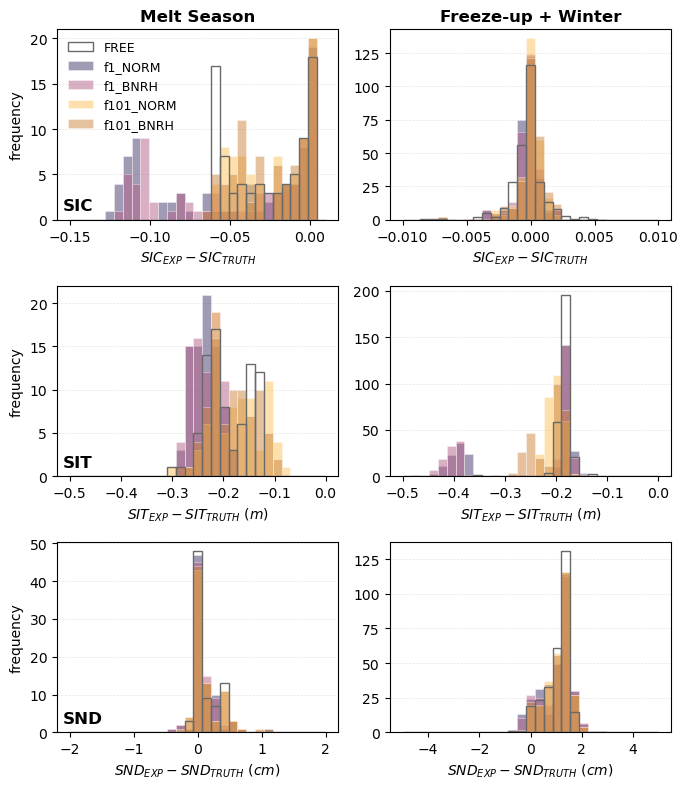

In [57]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize = (7,8))
plt.style.use('tableau-colorblind10')

# colors = ['cerulean','pumpkin','pictonblue','tenne']
# colors = ['#90a68d', '#f2e5d5','#f2b279', '#d97b73','#6c5b7b']
colors = ['dimgrey','#42376a','#b46088','#fcc25a', 'peru']#'#bf9000']'#90a68d',
labels = ['f1_NORM', 'f1_BNRH', 'f101_NORM', 'f101_BNRH']
x = obs_test.time.values[1:1092:3]
fup, flw, fem = calculate_error_bounds(free_ds)

for i in range(0,3):
    if i == 2: 
        obs = free_ds.isel({'ensemble_member':13}).vsnon.sum(dim='ncat')*100
        var = 'SND'
        unit = 'cm'
        year = fem.vsno*100 - obs
        summer_bins = np.linspace(-2,2,30)
        winter_bins = np.linspace(-5,5,30)
        
    elif i == 0:
        obs = truth.observations[1:1092:3].drop('copy').rename({'ObsIndex':'time'}).values
        var = 'SIC'
        unit = ''
        year = fem.aice - obs
        summer_bins = np.linspace(-0.15,0.01,30)
        winter_bins = np.linspace(-0.01,0.01,30)
        
    else:
        obs = truth.observations[0:1092:3].drop('copy').rename({'ObsIndex':'time'}).values
        var = 'SIT'
        unit = 'm'
        year = fem.hi - obs
        summer_bins = np.linspace(-0.5, 0,30)
        winter_bins = np.linspace(-0.5,0,30)
    
    axes[i][0].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[i][1].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[i][0].set_axisbelow(True)
    axes[i][1].set_axisbelow(True)
    
    summer = year.isel(time=slice(182, 182+80))
    winter = np.concatenate([year.isel(time=slice(0,182)).values, year.isel(time=slice(182+80, 365)).values])
    
    axes[i][0].hist(summer, bins=summer_bins, edgecolor=colors[0],
         linewidth=1, label = 'FREE', zorder = 10, fill = False)
    
    axes[i][1].hist(winter, bins=winter_bins, edgecolor=colors[0],
         linewidth=1, label = 'FREE', zorder = 10, fill = False)
    
    for count in range(0,len(CASES)):
        upperbound, lowerbound, pem = calculate_error_bounds(CASES[count])
        
        if i == 2: 
            year = pem.vsnon.sum(dim='ncat')*100 - obs
        elif i == 0:
            year = pem.aice - obs
        else:
            year = pem.hi - obs

        summer = year.isel(time=slice(182, 182+80))
        winter = np.concatenate([year.isel(time=slice(0,182)).values, year.isel(time=slice(182+80, 365)).values])
        
        axes[i][0].hist(summer, 
                 bins=summer_bins, color = colors[count+1], alpha=0.5, edgecolor='white',
                 linewidth=0.5, label = labels[count])
        axes[i][1].hist(winter, 
                 bins=winter_bins, color = colors[count+1], alpha=0.5, edgecolor='white',
                 linewidth=0.5, label = labels[count])
    if var == 'SIC':
        axes[i][0].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$', fontsize=10)
        axes[i][0].set_ylabel('frequency', fontsize=10)
        axes[i][1].set_xlabel('')
        axes[i][1].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$', fontsize=10)
    else:
        axes[i][0].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$ $('+unit+')$', fontsize=10)
        axes[i][0].set_ylabel('frequency', fontsize=10)
        axes[i][1].set_xlabel('')
        axes[i][1].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$ $('+unit+')$', fontsize=10)
    
    axes[i][0].text(0.02, 0.05, var,
                    transform=axes[i][0].transAxes,
                    fontsize=12, fontweight='bold',
                    # bbox=dict(boxstyle="none", facecolor="none", alpha=0.5),
                   )

axes[0][0].set_title('Melt Season', fontweight="bold", fontsize=12)
axes[0][1].set_title('Freeze-up + Winter', fontweight="bold", fontsize=12)
axes[0][0].legend(frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig('figures/'+var_og+'_algorithms_histplots.png', dpi=300, bbox_inches='tight')

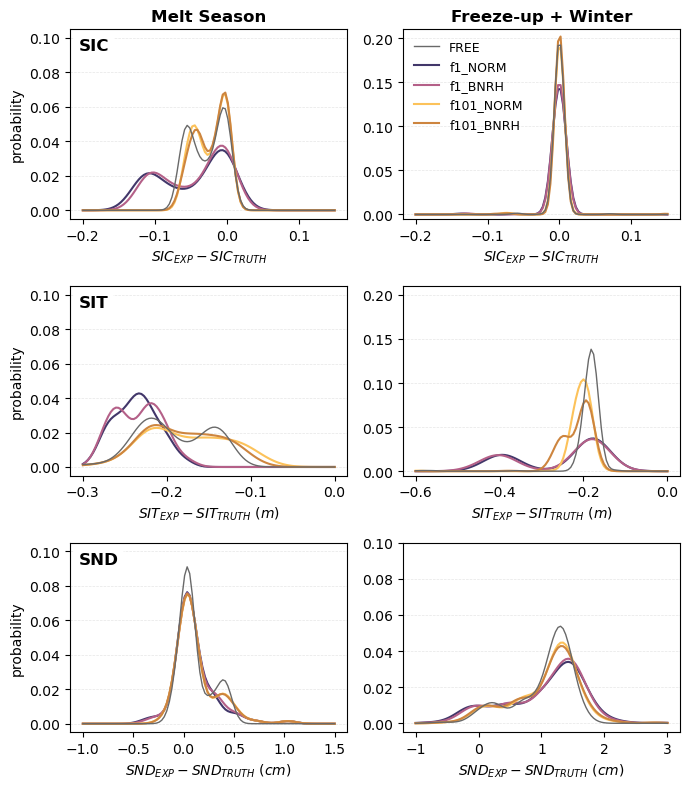

In [56]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize = (7,8))
plt.style.use('tableau-colorblind10')

# colors = ['cerulean','pumpkin','pictonblue','tenne']
# colors = ['#90a68d', '#f2e5d5','#f2b279', '#d97b73','#6c5b7b']
colors = ['dimgrey','#42376a','#b46088','#fcc25a', 'peru']#'#bf9000']'#90a68d',
labels = ['f1_NORM', 'f1_BNRH', 'f101_NORM', 'f101_BNRH']
x = obs_test.time.values[1:1092:3]
fup, flw, fem = calculate_error_bounds(free_ds)

for i in range(0,3):
    if i == 2: 
        obs = free_ds.isel({'ensemble_member':13}).vsnon.sum(dim='ncat')*100
        var = 'SND'
        unit = 'cm'
        year = fem.vsno*100 - obs
        wmax = 3
        wmin = -1
        smax = 1.5
        smin = -1
        
    elif i == 0:
        obs = truth.observations[1:1092:3].drop('copy').rename({'ObsIndex':'time'}).values
        var = 'SIC'
        unit = ''
        year = fem.aice - obs
        wmax = 0.15
        wmin = -0.2
        smax = 0.15
        smin = -0.2
        
    else:
        obs = truth.observations[0:1092:3].drop('copy').rename({'ObsIndex':'time'}).values
        var = 'SIT'
        unit = 'm'
        year = fem.hi - obs
        wmax = 0
        wmin = -0.6
        smax = 0
        smin = -0.3
    
    axes[i][0].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[i][1].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[i][0].set_axisbelow(True)
    axes[i][1].set_axisbelow(True)
    
    summer = year.isel(time=slice(182, 182+80))
    winter = np.concatenate([year.isel(time=slice(0,182)).values, year.isel(time=slice(182+80, 365)).values])
        
    skde = gaussian_kde(summer)
    wkde = gaussian_kde(winter)
        
    s_dist = np.linspace(smin, smax, 100)
    w_dist = np.linspace(wmin, wmax, 100)
    
    axes[i][0].plot(s_dist, skde(s_dist)/sum(skde(s_dist)), color = 'dimgrey',
         linewidth=1, label = 'FREE', zorder = 10)
    
    axes[i][1].plot(w_dist, wkde(w_dist)/sum(wkde(w_dist)), color = 'dimgrey',
         linewidth=1, label = 'FREE', zorder = 10)
    
    for count in range(0,len(CASES)):
        upperbound, lowerbound, pem = calculate_error_bounds(CASES[count])
        
        if i == 2: 
            year = pem.vsnon.sum(dim='ncat')*100 - obs
        elif i == 0:
            year = pem.aice - obs
        else:
            year = pem.hi - obs

        summer = year.isel(time=slice(182, 182+80))
        winter = np.concatenate([year.isel(time=slice(0,182)).values, year.isel(time=slice(182+80, 365)).values])
        
        skde = gaussian_kde(summer)
        wkde = gaussian_kde(winter)
        
        s_dist = np.linspace(smin, smax, 100)
        w_dist = np.linspace(wmin, wmax, 100)
    
        axes[i][0].plot(s_dist, skde(s_dist)/sum(skde(s_dist)), color = colors[count+1], label = labels[count])
        axes[i][1].plot(w_dist, wkde(w_dist)/sum(wkde(w_dist)), color = colors[count+1], label = labels[count])
    
    if var == 'SIC':
        axes[i][0].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$', fontsize=10)
        axes[i][0].set_ylabel('probability', fontsize=10)
        axes[i][1].set_xlabel('')
        axes[i][1].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$', fontsize=10)
    else:
        axes[i][0].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$ $('+unit+')$', fontsize=10)
        axes[i][0].set_ylabel('probability', fontsize=10)
        axes[i][1].set_xlabel('')
        axes[i][1].set_xlabel('$'+var+'_{EXP} - '+var+'_{TRUTH}$ $('+unit+')$', fontsize=10)
    
    axes[i][0].text(0.03, 0.89, var,
                    transform=axes[i][0].transAxes,
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor="white", edgecolor='none', alpha=1),
                   )
    
axes[0][0].set_ylim([-0.005, 0.105])
axes[1][0].set_ylim([-0.005, 0.105])
axes[2][0].set_ylim([-0.005, 0.105])

axes[0][1].set_ylim([-0.005, 0.21])
axes[1][1].set_ylim([-0.005, 0.21])
axes[2][1].set_ylim([-0.005, 0.1])

axes[0][0].set_title('Melt Season', fontweight="bold", fontsize=12)
axes[0][1].set_title('Freeze-up + Winter', fontweight="bold", fontsize=12)
axes[0][1].legend(frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig('figures/'+var_og+'_algorithms_pdfs.png', dpi=300, bbox_inches='tight')

### Uncertainty as a function of filter type

In [11]:
case_list = ['SIT_f1_NORM_test', 'SIT_f1_BNRH_test','SIT_f101_NORM_test','SIT_f101_BNRH_test']#,
             # 'SIC_f1_NORM_test', 'SIC_f1_BNRH_test','SIC_f101_NORM_test','SIC_f101_BNRH_test',
             # 'AIC_f1_NORM_test', 'AIC_f1_BNRH_test','AIC_f101_NORM_test','AIC_f101_BNRH_test'] #, 'SIC_f101_BNRH_test'] 

CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/postprocessed_sd.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    
    CASES.append(ds)

/glade/scratch/mollyw/ipykernel_3325/1014741791.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35, fontsize=10)


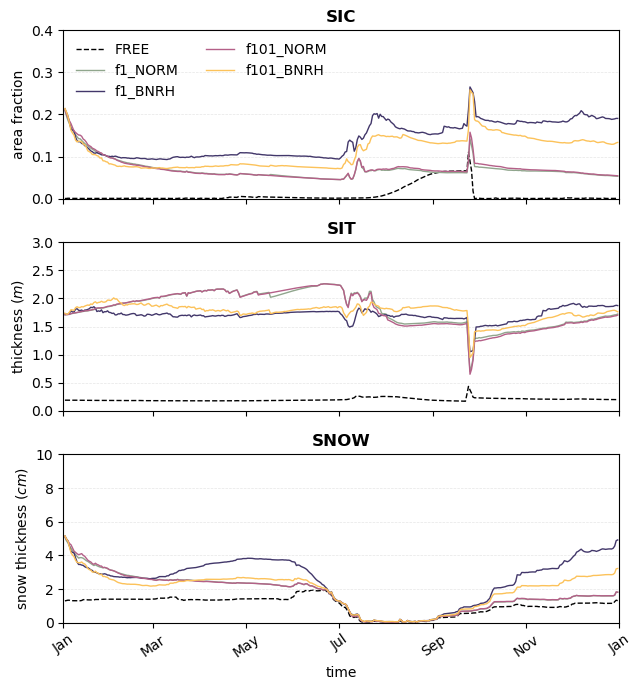

In [20]:
fig, axes = plt.subplots(nrows = 3, figsize = (6.5,7))

colors = ['#90a68d','#42376a','#b46088','#fcc25a','#bf9000']
labels = ['f1_NORM', 'f1_BNRH', 'f101_NORM', 'f101_BNRH']
titles = ['SIT','SIC','SNOW']

axes[0].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[1].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[2].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)

x = obs_test.time.values[0:1092:3]
axes[0].plot(x, free_ds.aice.std(dim='ensemble_member', ddof=1), c = 'black', label = 'FREE',linewidth = 1, linestyle='dashed', zorder = 1)
axes[1].plot(x, free_ds.hi.std(dim='ensemble_member', ddof=1), c = 'black', linewidth = 1, linestyle = 'dashed', zorder = 1)
axes[2].plot(x, free_ds.vsnon.sum(dim='ncat').std(dim='ensemble_member', ddof=1)*100, c = 'black',linewidth = 1, linestyle = 'dashed', zorder = 1)

count = 0
for case in case_list:
    exp = CASES[count]
    axes[0].plot(x, exp.aice, c = colors[count],label = labels[count], linewidth = 1, zorder = 4)
    axes[1].plot(x, exp.hi, c = colors[count], linewidth = 1, zorder = 4)
    axes[2].plot(x, exp.vsnon.sum(dim='ncat')*100, c = colors[count], linewidth = 1, zorder = 4)
    count +=1 

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35, fontsize=10)

axes[0].set_title(titles[1], fontweight="bold", fontsize=12)
axes[1].set_title(titles[0], fontweight="bold", fontsize=12)
axes[2].set_title(titles[2], fontweight="bold", fontsize=12)

axes[0].set_ylim([0,0.4])
axes[0].set_xlim([365*41+10, 365*42+10])
axes[0].set_ylabel('area fraction', fontsize=10)
axes[0].legend(frameon=False, ncols=2)

axes[1].set_ylim([0, 3])
axes[1].set_xlim([365*41+10, 365*42+10])
# axes[1].set_xlabel('time', fontsize=12, fontweight='bold', color='grey')
axes[1].set_ylabel('thickness $(m)$', fontsize=10)

axes[2].set_ylim([0,10])
axes[2].set_xlim([365*41+10, 365*42+10])
axes[2].set_xlabel('time')
axes[2].set_ylabel('snow thickness $(cm)$', fontsize=10)

plt.tight_layout()